# CS5616 - NLP - A4 - Text Classification

## 209338R - KATS Jayathilaka

#### -----------------------------------------------------------------------------------------------------

### 1. Importing and downloading NLTK Library and importing all other libraries

###### `conda install -c conda-forge pyspellchecker`

###### `conda install -c anaconda spacy`

In [1]:
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from spellchecker import SpellChecker
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
import re
import time
import string
import spacy
import nltk
import fasttext.util

import pandas as pd
import numpy as np

#### You have to change this directory according to your system. Otherwise, nltk.download() will always be invoked.

In [2]:
# I am KATS Jayathilaka - SINGHABAHU is my nickname
NLTK_DATA_PATH_CHECK = '/home/singhabahu/nltk_data/'

In [3]:
if not os.path.exists(NLTK_DATA_PATH_CHECK):
    nltk.download()
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')

### 2. Loading Raw Data

In [4]:
d_file = open('5000TravelQuestionsDataset.csv', encoding="latin-1")

df = pd.read_csv(d_file, header=None)
df.columns = ['text', 'class1', 'class2']

df.head()

,text,class1,class2
0,What are the special things we (husband and me...,TTD,TTDSIG
1,What are the companies which organize shark fe...,TTD,TTDOTH
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA
3,What are the best places around Cape Town for ...,TTD,TTDSIG
4,What are the best places to stay for a family ...,ACM,ACMOTH


### 3. Preprocessing

#### 3.1.Removing mistakenly entered `class1` and `class2` entries as follows.

##### 3.1.1. Stripping trailing and leading whitespaces and linebreaks from `class1` column

In [5]:
# coarse classes
df['class1'].value_counts()

TGU      1217
TTD      1139
TRS      1011
ACM       720
FOD       521
ENT       214
WTH       172
TGU\n       3
\nENT       2
TTD\n       1
Name: class1, dtype: int64

In [6]:
df.groupby('class1').get_group('TGU\n')

,text,class1,class2
524,Has anyone planned a simple wedding by themsel...,TGU\n,TGUPLN
3145,What are the Trans-Mongolian stop recommendati...,TGU\n,TGUOTH
3333,What is a good Civil Ceremony Venue for a wedd...,TGU\n,TGUOTH


In [7]:
df.groupby('class1').get_group('\nENT')

,text,class1,class2
3750,What are the best areas of town this year for ...,\nENT,ENTFES
3751,What to do on Riverwalk at Christmas time ?,\nENT,ENTFES


In [8]:
df.groupby('class1').get_group('TTD\n')

,text,class1,class2
3710,what is the best Zoo in Denmark ?,TTD\n,TTDSIG


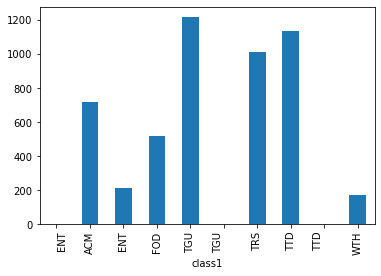

In [9]:
df.groupby('class1').text.count().plot.bar()

In [10]:
df['class1'] = df['class1'].str.strip()

##### Now there are exactly 7 coarse classes visible.

In [11]:
df['class1'].value_counts()

TGU    1220
TTD    1140
TRS    1011
ACM     720
FOD     521
ENT     216
WTH     172
Name: class1, dtype: int64

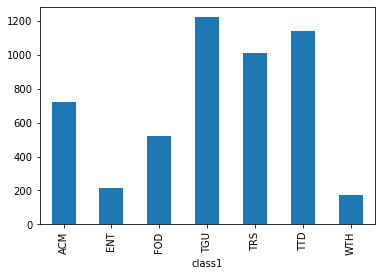

In [12]:
df.groupby('class1').text.count().plot.bar()

##### 3.1.2. Stripping trailing and leading whitespaces and linebreaks from `class2` column

In [13]:
# fine classes
df['class2'].value_counts()

TTDSIG      511
ACMHOT      342
TTDSPO      233
FODBAK      221
ACMOTH      207
           ... 
\nWTHOTH      1
ACMOTH\n      1
TTDSPO\n      1
TRSROU\n      1
TGUCIG\n      1
Name: class2, Length: 79, dtype: int64

In [14]:
df.groupby('class2').get_group('FODBAK\n')

,text,class1,class2
760,Can you suggest your favorite food stands for ...,FOD,FODBAK\n


In [15]:
df.groupby('class2').get_group('TTDSPO\n')

,text,class1,class2
3429,Where in Taormina can you watch Premier League...,TTD,TTDSPO\n


In [16]:
df.groupby('class2').get_group('ACMOTH\n')

,text,class1,class2
3567,What are the recommended reasonable accomodati...,ACM,ACMOTH\n


In [17]:
df.groupby('class2').get_group('TTDSIG\n')

,text,class1,class2
2601,What sites and places and activities are achie...,TTD,TTDSIG\n


In [18]:
df.groupby('class2').get_group('\nWTHOTH')

,text,class1,class2
4926,How is the weather in october in hampton?,WTH,\nWTHOTH


##### There are other mistakenly entered entries as well because here there are only 5 wrong groups from 79. But, there should be only 63 fine class labels. 

In [19]:
df['class2'] = df['class2'].str.strip()

##### Now there are only 63 fine classes visible

In [20]:
df['class2'].value_counts()

TTDSIG    512
ACMHOT    342
TRSOTH    242
TTDSPO    234
FODBAK    222
         ... 
ACMCAR      5
ACMBEA      5
TRSLIC      4
TGURES      3
TRSGAS      2
Name: class2, Length: 63, dtype: int64

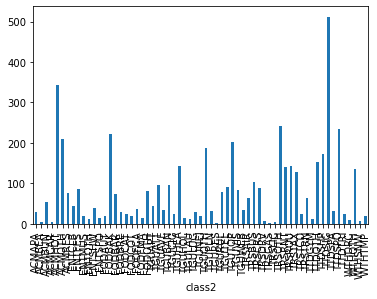

In [21]:
df.groupby('class2').text.count().plot.bar()

#### 3.2. Advanced Preprocessing Techniques

##### 3.2.1. Removing numbers

In [22]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

df['preprocessed_text'] = df['text'].apply(remove_numbers)
df['preprocessed_text']

0       What are the special things we (husband and me...
1       What are the companies which organize shark fe...
2       Is it safe for female traveller to go alone to...
3       What are the best places around Cape Town for ...
4       What are the best places to stay for a family ...
                              ...                        
4995    What is the best area to be based for sightsee...
4996    What are the good value traditional bars and r...
4997       What are the hotels near Alicante bus station?
4998       Where to stay in La Gomera to mountain biking?
4999    Is it possible to take a train trip from Santi...
Name: preprocessed_text, Length: 5000, dtype: object

##### 3.2.2. Removing punctuation marks

In [23]:
df['preprocessed_text'] = df['preprocessed_text'].str.translate(str.maketrans('','', string.punctuation))
df['preprocessed_text']

0       What are the special things we husband and me ...
1       What are the companies which organize shark fe...
2       Is it safe for female traveller to go alone to...
3       What are the best places around Cape Town for ...
4       What are the best places to stay for a family ...
                              ...                        
4995    What is the best area to be based for sightsee...
4996    What are the good value traditional bars and r...
4997        What are the hotels near Alicante bus station
4998        Where to stay in La Gomera to mountain biking
4999    Is it possible to take a train trip from Santi...
Name: preprocessed_text, Length: 5000, dtype: object

##### 3.2.3. Removing leading and trailing white spaces

In [24]:
df['preprocessed_text'] = df['preprocessed_text'].str.strip()
df['preprocessed_text']

0       What are the special things we husband and me ...
1       What are the companies which organize shark fe...
2       Is it safe for female traveller to go alone to...
3       What are the best places around Cape Town for ...
4       What are the best places to stay for a family ...
                              ...                        
4995    What is the best area to be based for sightsee...
4996    What are the good value traditional bars and r...
4997        What are the hotels near Alicante bus station
4998        Where to stay in La Gomera to mountain biking
4999    Is it possible to take a train trip from Santi...
Name: preprocessed_text, Length: 5000, dtype: object

##### 3.2.4. Converting to lowercase

In [25]:
df['preprocessed_text'] = df['preprocessed_text'].str.lower()
df['preprocessed_text']

0       what are the special things we husband and me ...
1       what are the companies which organize shark fe...
2       is it safe for female traveller to go alone to...
3       what are the best places around cape town for ...
4       what are the best places to stay for a family ...
                              ...                        
4995    what is the best area to be based for sightsee...
4996    what are the good value traditional bars and r...
4997        what are the hotels near alicante bus station
4998        where to stay in la gomera to mountain biking
4999    is it possible to take a train trip from santi...
Name: preprocessed_text, Length: 5000, dtype: object

##### 3.2.5. Removing stop words

In [26]:
def remove_english_stop_words(text):
    tokens = nltk.word_tokenize(text)
    filtered_words = [token for token in tokens if not token in stopwords.words('english')]
    return ' '.join(filtered_words)

df['preprocessed_text'] = df['preprocessed_text'].apply(remove_english_stop_words)
df['preprocessed_text']

0               special things husband day stay cape town
1       companies organize shark feeding events scuba ...
2                safe female traveller go alone cape town
3                     best places around cape town safari
4             best places stay family stay away nightlife
                              ...                        
4995                    best area based sightseeing palma
4996    good value traditional bars restaurants barcelona
4997                     hotels near alicante bus station
4998                       stay la gomera mountain biking
4999             possible take train trip santiago madrid
Name: preprocessed_text, Length: 5000, dtype: object

In [27]:
df.head()

,text,class1,class2,preprocessed_text
0,What are the special things we (husband and me...,TTD,TTDSIG,special things husband day stay cape town
1,What are the companies which organize shark fe...,TTD,TTDOTH,companies organize shark feeding events scuba ...
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,safe female traveller go alone cape town
3,What are the best places around Cape Town for ...,TTD,TTDSIG,best places around cape town safari
4,What are the best places to stay for a family ...,ACM,ACMOTH,best places stay family stay away nightlife


##### 3.2.6. Spell Correction

In [28]:
# THIS IS DONE TO STOP THE REPEATED RUNNING OF THE SPELL CORRECTION WHICH TAKES NEARLY 20 MINUTES FOR THE DATASET
DO_SPELL_CORRECTION = False

ENTRY_SIZE_FOR_CLARITY = 10
spc = SpellChecker()
def spell_correction(text):
    tokens = nltk.word_tokenize(text)
    spell_corrected_tokens = [spc.correction(token) for token in tokens]
    return ' '.join(spell_corrected_tokens)

In [29]:
if DO_SPELL_CORRECTION:
    TOTAL_ENTRIES = df.shape[0]
    start = time.time()
    for i in range(TOTAL_ENTRIES):
        df['preprocessed_text'][i] = spell_correction(df['preprocessed_text'][i])
        if i % ENTRY_SIZE_FOR_CLARITY == 0 and i != 0:
            print(f'[{i}/{TOTAL_ENTRIES}] entries checked and corrected. Elapsed Time: {round(time.time() - start, 2)} seconds ', end="\r")

##### 3.2.7. Lemmatization

In [30]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  lemmatized = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in nltk.word_tokenize(text)]
  return ' '.join(lemmatized)

df['lemmatized'] = df['preprocessed_text'].apply(lemmatize_text)
df['lemmatized']

0              special things husband day stay cape town
1        company organize shark feed events scuba divers
2               safe female traveller go alone cape town
3                     best place around cape town safari
4             best place stay family stay away nightlife
                              ...                       
4995                       best area base sightsee palma
4996    good value traditional bar restaurants barcelona
4997                    hotels near alicante bus station
4998                        stay la gomera mountain bike
4999            possible take train trip santiago madrid
Name: lemmatized, Length: 5000, dtype: object

In [31]:
df

,text,class1,class2,preprocessed_text,lemmatized
0,What are the special things we (husband and me...,TTD,TTDSIG,special things husband day stay cape town,special things husband day stay cape town
1,What are the companies which organize shark fe...,TTD,TTDOTH,companies organize shark feeding events scuba ...,company organize shark feed events scuba divers
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,safe female traveller go alone cape town,safe female traveller go alone cape town
3,What are the best places around Cape Town for ...,TTD,TTDSIG,best places around cape town safari,best place around cape town safari
4,What are the best places to stay for a family ...,ACM,ACMOTH,best places stay family stay away nightlife,best place stay family stay away nightlife
...,...,...,...,...,...
4995,What is the best area to be based for sightsee...,TTD,TTDSIG,best area based sightseeing palma,best area base sightsee palma
4996,What are the good value traditional bars and r...,FOD,FODBAR,good value traditional bars restaurants barcelona,good value traditional bar restaurants barcelona
4997,What are the hotels near Alicante bus station?,ACM,ACMHOT,hotels near alicante bus station,hotels near alicante bus station
4998,Where to stay in La Gomera to mountain biking?,TTD,TTDSPO,stay la gomera mountain biking,stay la gomera mountain bike


### 4. Text Classification

#### 4.1. SVM Classifier

##### 4.1.1. Bag of Words (BoW) with lemmatized tokens

###### Already the lemmatization was done as a preprocessing step.

In [32]:
df['lemmatized']

0              special things husband day stay cape town
1        company organize shark feed events scuba divers
2               safe female traveller go alone cape town
3                     best place around cape town safari
4             best place stay family stay away nightlife
                              ...                       
4995                       best area base sightsee palma
4996    good value traditional bar restaurants barcelona
4997                    hotels near alicante bus station
4998                        stay la gomera mountain bike
4999            possible take train trip santiago madrid
Name: lemmatized, Length: 5000, dtype: object

##### 4.1.2. POS Tags

In [33]:
def pos_tagger(text):
    pos_tagged = [tok_pos[0] + '_' + tok_pos[1] for tok_pos in pos_tag(nltk.word_tokenize(text), lang='eng')] 
    return ' '.join(pos_tagged)

df['pos_tagged'] = df['preprocessed_text'].apply(pos_tagger)
df['pos_tagged']

0       special_JJ things_NNS husband_NN day_NN stay_V...
1       companies_NNS organize_VBP shark_JJ feeding_VB...
2       safe_JJ female_NN traveller_NN go_VBP alone_RB...
3       best_JJS places_NNS around_IN cape_NN town_NN ...
4       best_JJS places_NNS stay_VBP family_NN stay_VB...
                              ...                        
4995    best_JJS area_NN based_VBN sightseeing_NN palm...
4996    good_JJ value_NN traditional_JJ bars_NNS resta...
4997     hotels_NNS near_IN alicante_JJ bus_NN station_NN
4998       stay_NN la_RB gomera_VBD mountain_NN biking_NN
4999    possible_JJ take_NN train_NN trip_NN santiago_...
Name: pos_tagged, Length: 5000, dtype: object

##### 4.1.3. Headword extraction

###### Install spaCy by: `conda install -c conda-forge spacy`

###### Install the `en_core_web_sm` by: `pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz`

###### Support from online resources
##### `https://github.com/explosion/spaCy/issues/7453`
##### `https://github.com/explosion/spaCy/issues/4577`
##### `https://spacy.io/models`

In [34]:
nlp = spacy.load('en_core_web_sm')
def headword_tokenizer(text):
    head_words = []
    for token in nlp(text):
        if token.dep_ == "nsubj" or token.dep_ == "dobj" or token.dep_ == "aux" or token.dep_ == "ROOT":
            head_words.append(token.text)
            head_words.append(token.head.text)
    unique_hw = list(set(head_words))
    return ' '.join(unique_hw)

# headword_tokenizer(df['preprocessed_text'][0])
df['headwords'] = df['preprocessed_text'].apply(headword_tokenizer)
df['headwords']

0                       stay things town
1       events companies organize divers
2                           traveller go
3                                 places
4                     stay places family
                      ...               
4995                    based area palma
4996          barcelona restaurants bars
4997                              hotels
4998                         stay biking
4999                    madrid trip take
Name: headwords, Length: 5000, dtype: object

##### 4.1.4. Headword Synonyms

In [35]:
max_syns = 2

def wordnet_synonyms(keywords):
  synonyms = []
  for keyword in keywords:
    count = 0
    for synset in wordnet.synsets(keyword):
      if count <= max_syns:
        for lemma in synset.lemmas():
          if count <= max_syns:
            synonyms.append(lemma.name())
          else: 
            break
        count = count + 1
      else:
        break

  unique_synonyms = list(set(synonyms))
  return ' '.join(synonyms)

df['headwords_synonyms'] = df['headwords'].apply(wordnet_synonyms)
df['headwords_synonyms']

0       second sec s sulfur S sulphur atomic_number_16...
1       vitamin_E tocopherol E einsteinium Es E atomic...
2       thymine T deoxythymidine_monophosphate T metri...
3       phosphorus P atomic_number_15 P p liter litre ...
4       second sec s sulfur S sulphur atomic_number_16...
                              ...                        
4995    bacillus B B-complex_vitamin B_complex vitamin...
4996    bacillus B B-complex_vitamin B_complex vitamin...
4997    hydrogen H atomic_number_1 henry H Planck's_co...
4998    second sec s sulfur S sulphur atomic_number_16...
4999    meter metre m molarity molar_concentration M t...
Name: headwords_synonyms, Length: 5000, dtype: object

##### 4.1.5. Named Entity Recognition (NER)

In [36]:
def named_entity_tokenizer(text):
    named_entities = []
    for ent in nlp(text).ents:
      named_entities.append(ent.text + '_' + ent.label_)
    return ' '.join(named_entities)

df['named_entities'] = df['text'].apply(named_entity_tokenizer)
df['named_entities']

0       5 day_DATE Cape Town_LOC
1                               
2                  Cape Town_GPE
3                  Cape Town_LOC
4                               
                  ...           
4995                   Palma_GPE
4996               Barcelona_GPE
4997                Alicante_GPE
4998               La Gomera_GPE
4999                  Madrid_GPE
Name: named_entities, Length: 5000, dtype: object

In [37]:
df

,text,class1,class2,preprocessed_text,lemmatized,pos_tagged,headwords,headwords_synonyms,named_entities
0,What are the special things we (husband and me...,TTD,TTDSIG,special things husband day stay cape town,special things husband day stay cape town,special_JJ things_NNS husband_NN day_NN stay_V...,stay things town,second sec s sulfur S sulphur atomic_number_16...,5 day_DATE Cape Town_LOC
1,What are the companies which organize shark fe...,TTD,TTDOTH,companies organize shark feeding events scuba ...,company organize shark feed events scuba divers,companies_NNS organize_VBP shark_JJ feeding_VB...,events companies organize divers,vitamin_E tocopherol E einsteinium Es E atomic...,
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,safe female traveller go alone cape town,safe female traveller go alone cape town,safe_JJ female_NN traveller_NN go_VBP alone_RB...,traveller go,thymine T deoxythymidine_monophosphate T metri...,Cape Town_GPE
3,What are the best places around Cape Town for ...,TTD,TTDSIG,best places around cape town safari,best place around cape town safari,best_JJS places_NNS around_IN cape_NN town_NN ...,places,phosphorus P atomic_number_15 P p liter litre ...,Cape Town_LOC
4,What are the best places to stay for a family ...,ACM,ACMOTH,best places stay family stay away nightlife,best place stay family stay away nightlife,best_JJS places_NNS stay_VBP family_NN stay_VB...,stay places family,second sec s sulfur S sulphur atomic_number_16...,
...,...,...,...,...,...,...,...,...,...
4995,What is the best area to be based for sightsee...,TTD,TTDSIG,best area based sightseeing palma,best area base sightsee palma,best_JJS area_NN based_VBN sightseeing_NN palm...,based area palma,bacillus B B-complex_vitamin B_complex vitamin...,Palma_GPE
4996,What are the good value traditional bars and r...,FOD,FODBAR,good value traditional bars restaurants barcelona,good value traditional bar restaurants barcelona,good_JJ value_NN traditional_JJ bars_NNS resta...,barcelona restaurants bars,bacillus B B-complex_vitamin B_complex vitamin...,Barcelona_GPE
4997,What are the hotels near Alicante bus station?,ACM,ACMHOT,hotels near alicante bus station,hotels near alicante bus station,hotels_NNS near_IN alicante_JJ bus_NN station_NN,hotels,hydrogen H atomic_number_1 henry H Planck's_co...,Alicante_GPE
4998,Where to stay in La Gomera to mountain biking?,TTD,TTDSPO,stay la gomera mountain biking,stay la gomera mountain bike,stay_NN la_RB gomera_VBD mountain_NN biking_NN,stay biking,second sec s sulfur S sulphur atomic_number_16...,La Gomera_GPE


##### 4.1.6. tf-idf Vectorization

In [38]:
def tfidf_vectorize(text):
  tfidfconverter = TfidfVectorizer(max_features=1500, min_df=1, max_df=0.7, stop_words=stopwords.words('english'))
  vctzr = tfidfconverter.fit_transform(text).toarray()
  return vctzr

print('BoW vec shape:', tfidf_vectorize(df['lemmatized']).shape)
print('POS tagged:', tfidf_vectorize(df['pos_tagged']).shape)
print('Head Words:', tfidf_vectorize(df['headwords']).shape)
print('Head Words Synonyms:', tfidf_vectorize(df['headwords_synonyms']).shape)
print('Named Entity:', tfidf_vectorize(df['named_entities']).shape)

BoW vec shape: (5000, 1500)
POS tagged: (5000, 1500)
Head Words: (5000, 1500)
Head Words Synonyms: (5000, 136)
Named Entity: (5000, 1500)


##### 4.1.7. Label encoding for class 1

In [39]:
le = LabelEncoder()

x_encoded = np.concatenate(
    (
        tfidf_vectorize(df['lemmatized']), 
        tfidf_vectorize(df['pos_tagged']), 
        tfidf_vectorize(df['headwords']), 
        tfidf_vectorize(df['headwords_synonyms']), 
        tfidf_vectorize(df['named_entities'])
    )
, axis=1)
y_encoded = le.fit_transform(df['class1'])

##### 4.1.8. SVM Model and Training

In [40]:
def calculate_accuracy(encoded_x, encoded_y):
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  fold = 0
  accuracies = []
  for train_index, test_index in cv.split(x_encoded):
      fold += 1
      X_train, X_test = encoded_x[train_index], encoded_x[test_index]
      y_train, y_test = encoded_y[train_index], encoded_y[test_index]
      SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
      SVM.fit(X_train,y_train)
      predictions = SVM.predict(X_test)
      acc = accuracy_score(predictions, y_test)*100
      accuracies.append(acc)
      print("Fold: {} - {} - {:.2f}".format(fold, "Accuracy: ",acc))
      
  print("Mean {:.2f} Standard Deviation {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

  return predictions, y_test


def accuracy_report(y_test, y_pred):
    
    print(classification_report(y_test,y_pred))

    acc = accuracy_score(y_test, y_pred) * 100
    print('Accuracy : %.3f' % acc)

    f1 =  f1_score(y_test, y_pred, average='weighted')
    print('F1 Score: %.3f' % f1)

    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n{}".format(cm))

    return f1

##### 4.1.9. Results for `class1` - All 5 features

In [167]:
start = time.time()
y_return = calculate_accuracy(x_encoded, y_encoded)
print(f'Time: {time.time() - start} seconds')

Fold: 1 - Accuracy:  - 78.80
Fold: 2 - Accuracy:  - 78.20
Fold: 3 - Accuracy:  - 76.20
Fold: 4 - Accuracy:  - 77.00
Fold: 5 - Accuracy:  - 77.20
Fold: 6 - Accuracy:  - 78.00
Fold: 7 - Accuracy:  - 79.80
Fold: 8 - Accuracy:  - 78.20
Fold: 9 - Accuracy:  - 77.60
Fold: 10 - Accuracy:  - 80.00
Mean 78.10 Standard Deviation 1.14


In [168]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        74
           1       0.70      0.84      0.76        19
           2       0.80      0.96      0.87        50
           3       0.73      0.78      0.76       105
           4       0.89      0.82      0.85       106
           5       0.78      0.68      0.73       130
           6       0.88      0.94      0.91        16

    accuracy                           0.80       500
   macro avg       0.80      0.84      0.82       500
weighted avg       0.80      0.80      0.80       500

Accuracy : 80.000
F1 Score: 0.799
Confusion Matrix: 
[[63  0  3  2  2  3  1]
 [ 0 16  0  1  0  2  0]
 [ 0  0 48  2  0  0  0]
 [ 4  2  3 82  3 10  1]
 [ 0  2  1  7 87  9  0]
 [ 9  3  5 18  6 89  0]
 [ 0  0  0  0  0  1 15]]


0.7988413552946779

##### 4.1.10. Label encoding for `class2`

In [41]:
le = LabelEncoder()

x_encoded = np.concatenate(
    (
        tfidf_vectorize(df['lemmatized']), 
        tfidf_vectorize(df['pos_tagged']), 
        tfidf_vectorize(df['headwords']), 
        tfidf_vectorize(df['headwords_synonyms']), 
        tfidf_vectorize(df['named_entities'])
    )
, axis=1)
y_encoded = le.fit_transform(df['class2'])

##### 4.1.11. Results for `class2` -  All 5 features

In [42]:
start = time.time()
y_return = calculate_accuracy(x_encoded, y_encoded)
print(f'Time: {time.time() - start} seconds')

Fold: 1 - Accuracy:  - 61.00
Fold: 2 - Accuracy:  - 59.40
Fold: 3 - Accuracy:  - 61.20
Fold: 4 - Accuracy:  - 59.60
Fold: 5 - Accuracy:  - 58.80
Fold: 6 - Accuracy:  - 59.00
Fold: 7 - Accuracy:  - 59.40
Fold: 8 - Accuracy:  - 61.20
Fold: 9 - Accuracy:  - 60.40
Fold: 10 - Accuracy:  - 61.20
Mean 60.12 Standard Deviation 0.93


In [43]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           2       0.62      1.00      0.77         5
           4       0.75      0.81      0.78        37
           5       0.76      0.70      0.73        23
           6       0.80      1.00      0.89         4
           7       0.00      0.00      0.00         3
           8       0.62      0.56      0.59         9
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         2
          11       0.57      0.80      0.67         5
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.77      0.63      0.69        27
          15       0.62      1.00      0.77        10
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         1
          19       0.25    

/home/singhabahu/anaconda3/envs/python38test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/singhabahu/anaconda3/envs/python38test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6137680787439387

##### 4.1.12. Results for `class1` - without `named_entities` feature (it results in records having NULL

In [45]:
le = LabelEncoder()

x_encoded_opt_ner = np.concatenate(
    (
        tfidf_vectorize(df['lemmatized']), 
        tfidf_vectorize(df['pos_tagged']), 
        tfidf_vectorize(df['headwords']), 
        tfidf_vectorize(df['headwords_synonyms']), 
    )
, axis=1)
x_encoded_opt_ner = le.fit_transform(df['class1'])

In [46]:
start = time.time()
y_return = calculate_accuracy(x_encoded, y_encoded)
print(f'Time: {time.time() - start} seconds')

KeyboardInterrupt: 

In [ ]:
accuracy_report(y_return[0], y_return[1])

##### 4.1.13. Results for `class1` - BoW Feature only

In [47]:
le = LabelEncoder()

x_encoded = tfidf_vectorize(df['lemmatized'])
y_encoded = le.fit_transform(df['class1'])

In [48]:
start = time.time()
y_return = calculate_accuracy(x_encoded, y_encoded)
print(f'Time: {time.time() - start} seconds')

Fold: 1 - Accuracy:  - 82.80
Fold: 2 - Accuracy:  - 81.40
Fold: 3 - Accuracy:  - 78.80
Fold: 4 - Accuracy:  - 79.60
Fold: 5 - Accuracy:  - 80.20
Fold: 6 - Accuracy:  - 79.80
Fold: 7 - Accuracy:  - 82.00
Fold: 8 - Accuracy:  - 81.20
Fold: 9 - Accuracy:  - 81.00
Fold: 10 - Accuracy:  - 80.80
Mean 80.76 Standard Deviation 1.13
Time: 414.49974274635315 seconds


In [49]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        72
           1       0.65      0.94      0.77        16
           2       0.82      0.94      0.87        52
           3       0.73      0.79      0.76       104
           4       0.91      0.82      0.86       109
           5       0.82      0.70      0.75       133
           6       0.82      1.00      0.90        14

    accuracy                           0.81       500
   macro avg       0.79      0.86      0.82       500
weighted avg       0.81      0.81      0.81       500

Accuracy : 80.800
F1 Score: 0.807
Confusion Matrix: 
[[62  0  3  2  1  4  0]
 [ 0 15  0  0  0  1  0]
 [ 1  0 49  2  0  0  0]
 [ 3  1  4 82  4 10  0]
 [ 1  3  1  8 89  6  1]
 [ 9  4  3 18  4 93  2]
 [ 0  0  0  0  0  0 14]]


0.8072469112763643

##### 4.1.13. Results for `class2` - BoW Feature only

In [50]:
le = LabelEncoder()

x_encoded = tfidf_vectorize(df['lemmatized'])
y_encoded = le.fit_transform(df['class2'])

In [51]:
start = time.time()
y_return = calculate_accuracy(x_encoded, y_encoded)
print(f'Time: {time.time() - start} seconds')

Fold: 1 - Accuracy:  - 64.20
Fold: 2 - Accuracy:  - 66.80
Fold: 3 - Accuracy:  - 65.00
Fold: 4 - Accuracy:  - 64.80
Fold: 5 - Accuracy:  - 65.80
Fold: 6 - Accuracy:  - 66.80
Fold: 7 - Accuracy:  - 64.60
Fold: 8 - Accuracy:  - 67.60
Fold: 9 - Accuracy:  - 64.80
Fold: 10 - Accuracy:  - 65.40
Mean 65.58 Standard Deviation 1.07
Time: 776.4438247680664 seconds


In [52]:
accuracy_report(y_return[0], y_return[1])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       0.62      1.00      0.77         5
           4       0.72      0.83      0.77        35
           5       0.81      0.71      0.76        24
           6       0.80      1.00      0.89         4
           7       0.00      0.00      0.00         2
           8       0.62      0.83      0.71         6
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.86      1.00      0.92         6
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.82      0.67      0.73        27
          15       0.81      1.00      0.90        13
          16       0.00      0.00      0.00         4
          17       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         1
          19       0.25    

/home/singhabahu/anaconda3/envs/python38test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/singhabahu/anaconda3/envs/python38test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.666165854064396

### 4.2. SVM Classifier with ‘fastText’ word embedding

###### To install fasttext: `pip install fasttext` or

###### To install fasttext: `conda install -c conda-forge fasttext`

###### Download fasttext model

In [53]:
# THIS IS ALREADY DOWNLOADED ONCE. HENCE, IT IS SKIPPED AS FOLLOWS.
if False:
    fasttext.util.download_model('en', if_exists='ignore')

In [56]:
ft = fasttext.load_model('cc.en.300.bin')
ft.get_dimension()

300

In [57]:
def tokenize(text):
    temp = nlp(text)
    return [str(token) for token in temp if not token.is_stop]

tokenized = [tokenize(text) for text in df.lemmatized]

In [58]:
def get_sentence_embedding(wordlist):
  embedding=ft.get_sentence_vector(wordlist)
  return embedding
  
embeddings = [np.mean(np.array(list(map(get_sentence_embedding,token))),axis=0) for token in tokenized]

x_encoded = np.array(embeddings)
x_encoded.shape

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_encoded_1 = le.fit_transform(df['class1'])
y_encoded_2 = le.fit_transform(df['class2'])

##### 4.2.1. Results for both classes `class1` and `class2`

In [59]:
start = time.time()
y_return_1 = calculate_accuracy(x_encoded, y_encoded_1)
print(f'Time: {time.time() - start} seconds')

Fold: 1 - Accuracy:  - 78.80
Fold: 2 - Accuracy:  - 77.40
Fold: 3 - Accuracy:  - 77.40
Fold: 4 - Accuracy:  - 77.40
Fold: 5 - Accuracy:  - 78.60
Fold: 6 - Accuracy:  - 78.00
Fold: 7 - Accuracy:  - 76.60
Fold: 8 - Accuracy:  - 79.80
Fold: 9 - Accuracy:  - 78.20
Fold: 10 - Accuracy:  - 79.60
Mean 78.18 Standard Deviation 0.98
Time: 63.84031057357788 seconds


In [60]:
accuracy_report(y_return_1[0], y_return_1[1])

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        71
           1       0.35      0.80      0.48        10
           2       0.82      0.94      0.87        52
           3       0.75      0.79      0.77       107
           4       0.88      0.87      0.87        99
           5       0.83      0.65      0.73       147
           6       0.82      1.00      0.90        14

    accuracy                           0.80       500
   macro avg       0.75      0.85      0.78       500
weighted avg       0.81      0.80      0.80       500

Accuracy : 79.600
F1 Score: 0.797
Confusion Matrix: 
[[62  0  1  2  2  3  1]
 [ 0  8  1  0  1  0  0]
 [ 1  1 49  0  0  1  0]
 [ 6  2  2 84  3  9  1]
 [ 0  1  1  5 86  6  0]
 [ 7 11  6 21  6 95  1]
 [ 0  0  0  0  0  0 14]]


0.7968300737168763

In [61]:
start = time.time()
y_return_2 = calculate_accuracy(x_encoded, y_encoded_2)
print(f'Time: {time.time() - start} seconds')

Fold: 1 - Accuracy:  - 57.60
Fold: 2 - Accuracy:  - 55.80
Fold: 3 - Accuracy:  - 56.40
Fold: 4 - Accuracy:  - 53.60
Fold: 5 - Accuracy:  - 54.80
Fold: 6 - Accuracy:  - 55.80
Fold: 7 - Accuracy:  - 53.80
Fold: 8 - Accuracy:  - 57.20
Fold: 9 - Accuracy:  - 56.00
Fold: 10 - Accuracy:  - 54.80
Mean 55.58 Standard Deviation 1.26
Time: 125.79759621620178 seconds


In [62]:
accuracy_report(y_return_2[0], y_return_2[1])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.72      0.64      0.68        45
           5       0.52      0.58      0.55        19
           6       0.60      1.00      0.75         3
           7       0.00      0.00      0.00         1
           8       0.38      1.00      0.55         3
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          14       0.77      0.49      0.60        35
          15       0.50      1.00      0.67         8
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         1
          19       0.00      0.00      0.00         0
          20       0.00    

/home/singhabahu/anaconda3/envs/python38test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5856556661286672

### 4.3. LSTM Text Classifier

##### 4.3.1. Label Encoding for both classes `class1` and `class2`

###### To install keras: `conda install -c conda-forge keras`

In [65]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

le = LabelEncoder()

y_encoded_1 = le.fit_transform(df['class1'])
y_encoded_2 = le.fit_transform(df['class2'])

In [68]:
max_words = 5000
max_len = 25
tok = Tokenizer(num_words=max_words, split=' ')
tok.fit_on_texts(df['preprocessed_text'].values)
seqs = tok.texts_to_sequences(df.lemmatized.values)
seqs_mat = sequence.pad_sequences(seqs,maxlen=max_len)

seqs_mat.shape

(5000, 25)

##### 4.3.2. LSTM Network and Training

In [69]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SpatialDropout1D

def MODEL_LSTM(num_classes):
    model = Sequential()
    model.add(Embedding(5000, 160, input_length=seqs_mat.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [70]:
y_mat_1 = pd.get_dummies(df['class1']).values
y_mat_1.shape

(5000, 7)

In [71]:
y_mat_2 = pd.get_dummies(df['class2']).values
y_mat_2.shape

(5000, 63)

In [72]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def evaluate_lstm(seqs, seqs_mat, y_mat, num_classes):
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  fold = 0
  accuracies = []
  for train_index, test_index in cv.split(seqs):
    fold += 1
    X_train, X_test = seqs_mat[train_index], seqs_mat[test_index]
    y_train, y_test = y_mat[train_index], y_mat[test_index]

    model = MODEL_LSTM(num_classes)
    model.fit(X_train, y_train, epochs=5, batch_size=64,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

    predictions = model.predict(X_test)

    fine_pred = [np.argmax(p) for p in predictions]
    fine_gt = [np.argmax(p) for p in y_test]
    f1 = accuracy_report(fine_pred, fine_gt)

    accuracies.append(f1)
    
  print("Mean {:.2f} Std {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

##### 4.3.3. Results of LSTM for both classes `class1` and `class2`

In [73]:
start = time.time()
evaluate_lstm(seqs, seqs_mat, y_mat_1, 7)
print(f'Time: {time.time() - start} seconds')

Epoch 1/5
64/64 [==============================] - 26s 399ms/step - loss: 1.7222 - accuracy: 0.2916 - val_loss: 1.9206 - val_accuracy: 0.1244
Epoch 2/5
64/64 [==============================] - 30s 462ms/step - loss: 0.9687 - accuracy: 0.6933 - val_loss: 1.2897 - val_accuracy: 0.5556
Epoch 3/5
64/64 [==============================] - 31s 485ms/step - loss: 0.4749 - accuracy: 0.8410 - val_loss: 0.8330 - val_accuracy: 0.7267
Epoch 4/5
64/64 [==============================] - 31s 477ms/step - loss: 0.2695 - accuracy: 0.9227 - val_loss: 1.0460 - val_accuracy: 0.7044
Epoch 5/5
64/64 [==============================] - 31s 479ms/step - loss: 0.1516 - accuracy: 0.9553 - val_loss: 0.9547 - val_accuracy: 0.7178
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        84
           1       0.56      0.67      0.61        21
           2       0.82      0.90      0.86        51
           3       0.86      0.71      0.77       129
           4       

In [75]:
start = time.time()
evaluate_lstm(seqs, seqs_mat, y_mat_2, 63)
print(f'Time: {time.time() - start} seconds')

Epoch 1/5
64/64 [==============================] - 27s 417ms/step - loss: 3.7669 - accuracy: 0.0753 - val_loss: 3.4735 - val_accuracy: 0.1378
Epoch 2/5
64/64 [==============================] - 31s 478ms/step - loss: 3.6005 - accuracy: 0.1190 - val_loss: 3.2924 - val_accuracy: 0.2933
Epoch 3/5
64/64 [==============================] - 32s 506ms/step - loss: 2.7890 - accuracy: 0.3343 - val_loss: 2.4034 - val_accuracy: 0.4467
Epoch 4/5
64/64 [==============================] - 34s 535ms/step - loss: 1.7345 - accuracy: 0.5965 - val_loss: 2.0792 - val_accuracy: 0.5178
Epoch 5/5
64/64 [==============================] - 35s 552ms/step - loss: 1.1184 - accuracy: 0.7341 - val_loss: 2.0075 - val_accuracy: 0.5311
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       

/home/singhabahu/anaconda3/envs/python38test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.25      0.50      0.33         2
           3       0.00      0.00      0.00         0
           4       0.90      0.70      0.79        54
           5       0.77      0.63      0.69        27
           6       0.90      0.64      0.75        14
           7       0.40      0.67      0.50         3
           8       0.67      0.91      0.77        11
           9       0.50      0.33      0.40         3
          10       0.00      0.00      0.00         0
          11       0.50      1.00      0.67         1
          13       0.00      0.00      0.00         1
          14       0.89      0.74      0.81        23
          15       0.75      0.38      0.50         8
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         2
          19       0.00    

64/64 [==============================] - 32s 505ms/step - loss: 1.5875 - accuracy: 0.6294 - val_loss: 1.9804 - val_accuracy: 0.5200
Epoch 5/5
64/64 [==============================] - 31s 491ms/step - loss: 1.0508 - accuracy: 0.7474 - val_loss: 1.8367 - val_accuracy: 0.5444
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         0
           2       0.33      0.50      0.40         2
           4       0.85      0.74      0.79        31
           5       0.70      0.61      0.65        23
           6       0.50      1.00      0.67         2
           7       0.50      1.00      0.67         1
           8       0.60      0.38      0.46         8
           9       0.00      0.00      0.00         0
          11       0.33      0.09      0.14        11
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.89

64/64 [==============================] - 30s 470ms/step - loss: 3.7498 - accuracy: 0.0689 - val_loss: 3.4182 - val_accuracy: 0.0133
Epoch 2/5
64/64 [==============================] - 32s 507ms/step - loss: 3.5715 - accuracy: 0.1190 - val_loss: 3.1746 - val_accuracy: 0.3044
Epoch 3/5
64/64 [==============================] - 32s 503ms/step - loss: 2.5908 - accuracy: 0.3864 - val_loss: 2.1742 - val_accuracy: 0.5089
Epoch 4/5
64/64 [==============================] - 32s 503ms/step - loss: 1.5587 - accuracy: 0.6299 - val_loss: 1.9228 - val_accuracy: 0.5111
Epoch 5/5
64/64 [==============================] - 32s 499ms/step - loss: 1.0196 - accuracy: 0.7556 - val_loss: 1.8886 - val_accuracy: 0.5667
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           2       0.12      0.50      0.20         2
           4       0.80      0.80      0.80        40
           5       0.67      0.64      0.65        22
           6       0.60      

### 4.4. BERT Based Classifier

##### 4.4.1. Label Encoding for both classes `class1` and `class2`

In [32]:
possible_labels_1 = df['class1'].unique()
possible_labels_2 = df['class2'].unique()

label_dict_1 = {}
for index, possible_label in enumerate(possible_labels_1):
    label_dict_1[possible_label] = index
print('COURSE CLASSES')
label_dict_1

COURSE CLASSES


{'TTD': 0, 'TGU': 1, 'ACM': 2, 'TRS': 3, 'WTH': 4, 'FOD': 5, 'ENT': 6}

In [33]:
print('FINE CLASSES')
label_dict_2 = {}
for index, possible_label in enumerate(possible_labels_2):
    label_dict_2[possible_label] = index
label_dict_2

FINE CLASSES


{'TTDSIG': 0,
 'TTDOTH': 1,
 'TGUHEA': 2,
 'ACMOTH': 3,
 'TRSTRN': 4,
 'TGUBAN': 5,
 'WTHTMP': 6,
 'TGUNEI': 7,
 'TTDSPO': 8,
 'ACMAPA': 9,
 'TRSOTH': 10,
 'TRSAIR': 11,
 'TRSROU': 12,
 'TGUOTH': 13,
 'ACMRES': 14,
 'ACMBUN': 15,
 'TRSCRS': 16,
 'WTHDRC': 17,
 'TRSRNT': 18,
 'TGUTOP': 19,
 'FODOTH': 20,
 'TGUVIS': 21,
 'FODAUT': 22,
 'TTDTRI': 23,
 'TGUPLN': 24,
 'TRSTAX': 25,
 'WTHOTH': 26,
 'TRSBUS': 27,
 'ACMHOT': 28,
 'TGULUG': 29,
 'FODBAK': 30,
 'TTDSPA': 31,
 'FODBRE': 32,
 'TGUATT': 33,
 'ENTCLB': 34,
 'TGUAVE': 35,
 'TGUTEL': 36,
 'TGUCIG': 37,
 'TTDSHP': 38,
 'TRSTCD': 39,
 'ACMBEA': 40,
 'FODCOT': 41,
 'TGUAPT': 42,
 'TRSLIC': 43,
 'TGULAU': 44,
 'TTDGYM': 45,
 'FODCAT': 46,
 'FODBAR': 47,
 'TGUHOL': 48,
 'ENTFES': 49,
 'TGURUL': 50,
 'TGURES': 51,
 'ACMCAR': 52,
 'FODFMA': 53,
 'ENTSHW': 54,
 'TRSGAS': 55,
 'WTHSNW': 56,
 'ENTMUS': 57,
 'ENTSPO': 58,
 'TGUWEB': 59,
 'TRSDRV': 60,
 'FODFCA': 61,
 'ENTOTH': 62}

In [34]:
df['class1_enc'] = df.class1.replace(label_dict_1)
df['class2_enc'] = df.class2.replace(label_dict_2)
df.head(10)

,text,class1,class2,preprocessed_text,lemmatized,class1_enc,class2_enc
0,What are the special things we (husband and me...,TTD,TTDSIG,special things husband day stay cape town,special things husband day stay cape town,0,0
1,What are the companies which organize shark fe...,TTD,TTDOTH,companies organize shark feeding events scuba ...,company organize shark feed events scuba divers,0,1
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,safe female traveller go alone cape town,safe female traveller go alone cape town,1,2
3,What are the best places around Cape Town for ...,TTD,TTDSIG,best places around cape town safari,best place around cape town safari,0,0
4,What are the best places to stay for a family ...,ACM,ACMOTH,best places stay family stay away nightlife,best place stay family stay away nightlife,2,3
5,What are the train services that travels from ...,TRS,TRSTRN,train services travels cape town oudtshoorn,train service travel cape town oudtshoorn,3,4
6,What are the best places to spend about 2 week...,ACM,ACMOTH,best places spend weeks relaxing honeymoon sou...,best place spend weeks relax honeymoon south a...,2,3
7,Can we use travellers cheques and credit cards...,TGU,TGUBAN,use travellers cheques credit cards cape town,use travellers cheque credit card cape town,1,5
8,Is it warm enough to swim in early September i...,WTH,WTHTMP,warm enough swim early september cape town,warm enough swim early september cape town,4,6
9,What are the best beaches for shelling in Cape...,TTD,TTDSIG,best beaches shelling capetown,best beach shell capetown,0,0


##### 4.4.2. Train and Validation Split

In [35]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(df.index.values, 
                                                  df.class1_enc.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.class1_enc.values)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(df.index.values, 
                                                  df.class2_enc.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.class2_enc.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train_1, 'data_type'] = 'train'
df.loc[X_val_1, 'data_type'] = 'val'

df.loc[X_train_2, 'data_type'] = 'train'
df.loc[X_val_2, 'data_type'] = 'val'

In [36]:
df.groupby(['class1', 'class1_enc', 'data_type']).count()

text  class2  preprocessed_text  lemmatized  \
class1 class1_enc data_type                                                
ACM    2          train       612     612                612         612   
                  val         108     108                108         108   
ENT    6          train       184     184                184         184   
                  val          32      32                 32          32   
FOD    5          train       442     442                442         442   
                  val          79      79                 79          79   
TGU    1          train      1038    1038               1038        1038   
                  val         182     182                182         182   
TRS    3          train       860     860                860         860   
                  val         151     151                151         151   
TTD    0          train       968     968                968         968   
                  val         172     172                172         172   
WTH    4          train       146     146                146         146   
                  val          26      26                 26          26   

                             class2_enc  
class1 class1_enc data_type              
ACM    2          train             612  
                  val               108  
ENT    6          train             184  
                  val                32  
FOD    5          train             442  
                  val                79  
TGU    1          train            1038  
                  val               182  
TRS    3          train             860  
                  val               151  
TTD    0          train             968  
                  val               172  
WTH    4          train             146  
                  val                26

In [37]:
df.groupby(['class2', 'class2_enc', 'data_type']).count()

text  class1  preprocessed_text  lemmatized  \
class2 class2_enc data_type                                                
ACMAPA 9          train        25      25                 25          25   
                  val           4       4                  4           4   
ACMBEA 40         train         4       4                  4           4   
                  val           1       1                  1           1   
ACMBUN 15         train        45      45                 45          45   
...                           ...     ...                ...         ...   
WTHOTH 26         val          20      20                 20          20   
WTHSNW 56         train         6       6                  6           6   
                  val           1       1                  1           1   
WTHTMP 6          train        17      17                 17          17   
                  val           3       3                  3           3   

                             class1_enc  
class2 class2_enc data_type              
ACMAPA 9          train              25  
                  val                 4  
ACMBEA 40         train               4  
                  val                 1  
ACMBUN 15         train              45  
...                                 ...  
WTHOTH 26         val                20  
WTHSNW 56         train               6  
                  val                 1  
WTHTMP 6          train              17  
                  val                 3  

[124 rows x 5 columns]

##### 4.4.3. BertTokenizer and Encoding the Data

###### Install Torch by: `conda install -c pytorch pytorch`

###### Install Transformers by: `conda install -c conda-forge transformers` or

###### Install Transformers by: `pip3 install transformers` or

###### Install Transformers by: `conda install -c huggingface transformers`

###### Install `sacremoses`: `pip3 install sacremoses`  - still PackageNotFound error for sacremoses

###### Install `sacremoses`: `conda install pytorch torchvision cudatoolkit=10.0 -c pytorch'

###### `conda create --name hf-transformers -c conda-forge transformers`

###### `https://www.gitmemory.com/issue/huggingface/tokenizers/685/826136101`

###### `conda install -c huggingface tokenizers=0.10.1 transformers=4.6.1` - this resoved error - versioning error

###### To solve this error, try the following code lines : `ModuleNotFoundError: No module named 'transformers.models.bert.tokenization_bert'`

###### `pip uninstall transformers`
###### `pip install transformers==3.5`

###### After restarting the jupyter notebook, error vanished after the installation.

In [38]:
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].lemmatized.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].lemmatized.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train_1 = torch.tensor(df[df.data_type=='train'].class1_enc.values)
labels_train_2 = torch.tensor(df[df.data_type=='train'].class2_enc.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val_1 = torch.tensor(df[df.data_type=='val'].class1_enc.values)
labels_val_2 = torch.tensor(df[df.data_type=='val'].class2_enc.values)

dataset_train_1 = TensorDataset(input_ids_train, attention_masks_train, labels_train_1)
dataset_val_1 = TensorDataset(input_ids_val, attention_masks_val, labels_val_1)
dataset_train_2 = TensorDataset(input_ids_train, attention_masks_train, labels_train_2)
dataset_val_2 = TensorDataset(input_ids_val, attention_masks_val, labels_val_2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/singhabahu/anaconda3/envs/python38test/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2016: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


##### 4.4.4. BERT Pre-trained Model

In [40]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_1),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

##### 4.4.5. Data Loaders

In [41]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train_1 = DataLoader(dataset_train_1, 
                              sampler=RandomSampler(dataset_train_1), 
                              batch_size=batch_size)

dataloader_validation_1 = DataLoader(dataset_val_1, 
                                   sampler=SequentialSampler(dataset_val_1),
                                   batch_size=batch_size)

dataloader_train_2 = DataLoader(dataset_train_2, 
                              sampler=RandomSampler(dataset_train_2), 
                              batch_size=batch_size)

dataloader_validation_2 = DataLoader(dataset_val_2, 
                                   sampler=SequentialSampler(dataset_val_2),
                                   batch_size=batch_size)

##### 4.4.6. Optimizer & Scheduler

In [42]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_1)*epochs)

##### 4.4.7. Performance Metrics

In [43]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, dict):
    label_dict_inverse = {v: k for k, v in dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

##### 4.4.8. Training Loop

In [44]:
import random
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# device = torch.device("cuda:0")
device = torch.device("cpu")

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val) 

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

start = time.time()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_1, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.to(device)
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        # optimizer = optim.Adam(model.parameters())
        optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
        # optimizer.load_state_dict(checkpoint['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'/content/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train_1)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation_1)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    print(f'Time: {time.time() - start} seconds')

/home/singhabahu/anaconda3/envs/python38test/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


FileNotFoundError: [Errno 2] No such file or directory: '/content/finetuned_BERT_epoch_1.model'

##### 4.4.9. Loading and Evaluating the Model

##### Results for `class1`

In [1]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_1),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

# model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_1.model', map_location=torch.device('cuda:0')))
model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

start = time.time()
_, predictions, true_vals = evaluate(dataloader_validation)
print(f'Time: {time.time() - start} seconds')
    
fine_pred = [np.argmax(p) for p in predictions]
fine_gt = [np.argmax(p) for p in true_vals]

val_acc = accuracy_score(fine_gt, fine_pred)*100
f1 =  f1_score(fine_pred, fine_gt, average='weighted')

print(classification_report(fine_gt,fine_pred))
print('Accuracy : %.3f' % val_acc)
print('F1 Score: %.3f' % f1)
cm = confusion_matrix(fine_gt, fine_pred)
print("Confusion Matrix: \n{}".format(cm))

NameError: name 'BertForSequenceClassification' is not defined

##### Results for `class2`

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict_2),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

# model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_1.model', map_location=torch.device('cuda:0')))
model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

start = time.time()
_, predictions, true_vals = evaluate(dataloader_validation)
print(f'Time: {time.time() - start} seconds')
    
fine_pred = [np.argmax(p) for p in predictions]
fine_gt = [np.argmax(p) for p in true_vals]

val_acc = accuracy_score(fine_gt, fine_pred)*100
f1 =  f1_score(fine_pred, fine_gt, average='weighted')

print(classification_report(fine_gt,fine_pred))
print('Accuracy : %.3f' % val_acc)
print('F1 Score: %.3f' % f1)
cm = confusion_matrix(fine_gt, fine_pred)
print("Confusion Matrix: \n{}".format(cm))